In [1]:
import sys
cwd = "/Users/jordydikkers/personal/projects/machi-koro-ai"
sys.path.append(cwd)
import os
os.chdir(cwd)

In [16]:
import pickle
import torch
from buffer import Buffer, BigBuffer
import matplotlib.pyplot as plt
from env import GymMachiKoro, MachiKoro
from mcts_agent import MCTSAgent
import torch.nn as nn
import gym
import numpy as np
from collections import OrderedDict


In [3]:
# for i in range(10):
#     with open(f"checkpoints/{i}.pkl", "rb") as file:
#         buffer = pickle.load(file)

#     buffer2 = BigBuffer(1, observation_space=buffer._observation_space, action_space=buffer._action_space)

#     buffer2.combine_buffers([buffer])
#     if buffer2._size != len(buffer2.obss):
#         a=1
#     with open(f"checkpoints2/{i}.pkl","wb") as file:
#         pickle.dump(buffer2, file)
    

In [4]:
# buffers = []
# for i in range(10):
#     with open(f"checkpoints/{i}.pkl", "rb") as file:
#         buffers.append(pickle.load(file))

# buffer = buffers[0].get_big_buffer()
# buffer.combine_buffers(buffers)

# buffer.compute_values()

In [5]:
# for i in range(8):
#     with open(f"checkpoints/{i}.pkl", "rb") as file:
#         buffer = pickle.load(file)
#         print(buffer.size)

42132


In [7]:
class PVNet(nn.Module):
    def __init__(
            self,
            observation_space: gym.Space,
            action_space: gym.Space,
    ):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        num_inputs = gym.spaces.flatten_space(observation_space).shape[0]
        num_outputs = action_space.n
        
        # self.fc1 = nn.Linear(num_inputs, 128)
        # self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, num_outputs)

        # self.fc4 = nn.Linear(128, 64)
        # self.fc5 = nn.Linear(64, 1)

        self.fctrunk = nn.Linear(num_inputs, 10)
        self.fclogits = nn.Linear(10, num_outputs)
        self.KLDiv = torch.nn.KLDivLoss(reduction="batchmean")

        self.fcvalue = nn.Linear(10, 1)

    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        
        # x = torch.relu(self.fc2(x))
        # policy = self.fc3(x)
        # x = torch.relu(self.fc4(x))
        # value = torch.tanh(self.fc5(x))
        trunk = torch.relu(self.fctrunk(x))

        logits = self.fclogits(trunk)

        value = torch.tanh(self.fcvalue(trunk))
        # return policy, value
        return logits, value # torch.ones(self.action_space.n)/self.action_space.n

    def predict(self, observation):
        input = torch.tensor(gym.spaces.flatten(self.observation_space, observation)).unsqueeze(0).to(torch.float32)
        # policy_pred, value_pred = self.forward(input)
        value_pred = self.forward(input)

        # policy_pred = torch.nn.functional.softmax(policy_pred, 1)

        # return policy_pred.squeeze().detach().numpy(), value_pred.detach().numpy().item()
        return value_pred.detach().numpy().item()

    def loss_fn(self, policy_preds, value_preds, policy_targets, value_targets):
            policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), torch.tensor(policy_targets).to(torch.float32))
            value_loss = torch.nn.functional.mse_loss(value_preds, torch.tensor(value_targets).to(torch.float32))
            return value_loss + policy_loss

    def train(self, train_buffer, val_buffer, batch_size, epochs):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        

        for epoch in range(epochs):
            train_batches = train_buffer.get_random_batches(batch_size = batch_size)

            tot_train_loss = 0
            train_steps_since_last_val_step = 0
            for i, batch in enumerate(train_batches):
                train_steps_since_last_val_step += 1
                obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = batch
                
                # policy_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                prob_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                loss = self.loss_fn(
                    policy_preds=prob_preds,
                    value_preds=value_preds,
                    policy_targets=probs,
                    value_targets=values
                )
                tot_train_loss += loss
                if i % 100 == 0:
                    obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = val_buffer[:]
                    # policy_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                    prob_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                    avg_val_loss = self.loss_fn(
                        policy_preds=prob_preds,
                        value_preds=value_preds,
                        policy_targets=probs,
                        value_targets=values
                    )
                    avg_train_loss = tot_train_loss/train_steps_since_last_val_step
                    print(f"epoch: {epoch} | train_loss: {avg_train_loss} | val_loss: {avg_val_loss}")
                    tot_train_loss = 0
                    train_steps_since_last_val_step = 0
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

In [8]:
env = MachiKoro(n_players=2)
env = GymMachiKoro(env)

pvnet = torch.load("checkpoints/8.pt") # PVNet(env.observation_space, env.action_space)

In [48]:
new_obs_space_keys = [
    'current_player-Harbor',
    'current_player-Train Station',
    'current_player-Shopping Mall',
    'current_player-Amusement Park',
    'current_player-Moon Tower',
    'current_player-Airport',
    'current_player-coins',
    'player_current_p_1-Harbor',
    'player_current_p_1-Train Station',
    'player_current_p_1-Shopping Mall',
    'player_current_p_1-Amusement Park',
    'player_current_p_1-Moon Tower',
    'player_current_p_1-Airport',
    'player_current_p_1-coins',
    'action_mask',
    ]
new_observation_space = gym.spaces.Dict(OrderedDict([(key, env.observation_space[key]) for key in new_obs_space_keys]))
new_observation_space

space_indices = {}
cur_index = 0

for name, space in env.observation_space.items():
    if isinstance(space, gym.spaces.Box):
        space_indices[name] = list(range(cur_index, cur_index + 1))
        cur_index+=1
    else:
        space_indices[name] = list(range(cur_index, cur_index + space.n))
        cur_index+=space.n

new_obs_space_indices = []
for space in new_obs_space_keys:
    new_obs_space_indices += space_indices[space]

42132

In [ ]:
old_obss = buffer.obss
new_obss = np.zeros((buffer.size, gym.spaces.flatten_space(new_observation_space).shape[0]))
for i in range(buffer.size):
    old_obs = gym.spaces.unflatten(env.observation_space, old_obss[0])
    new_obs = OrderedDict([(key, old_obs[key]) for key in new_obs_space_keys])
    new_obss[i] = gym.spaces.flatten(new_observation_space, new_obs)
buffer._obss = new_obss

42132


/var/folders/4k/zq7y_vc10hz_rjss8lkyh9640000gn/T/ipykernel_18119/426180530.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), torch.tensor(policy_targets).to(torch.float32))


epoch: 0 | train_loss: 4.05033016204834 | val_loss: 4.542379856109619
epoch: 0 | train_loss: 2.0811195373535156 | val_loss: 1.77107834815979
epoch: 0 | train_loss: 1.610680103302002 | val_loss: 1.5984082221984863
epoch: 0 | train_loss: 1.575706124305725 | val_loss: 1.5751419067382812
epoch: 0 | train_loss: 1.5382159948349 | val_loss: 1.531855821609497
epoch: 0 | train_loss: 1.5201280117034912 | val_loss: 1.5417405366897583
epoch: 1 | train_loss: 1.4495025873184204 | val_loss: 1.5651545524597168
epoch: 1 | train_loss: 1.5612907409667969 | val_loss: 1.5293653011322021
epoch: 1 | train_loss: 1.4995313882827759 | val_loss: 1.5062397718429565
epoch: 1 | train_loss: 1.501197099685669 | val_loss: 1.5034518241882324
epoch: 1 | train_loss: 1.4918442964553833 | val_loss: 1.4937015771865845
epoch: 1 | train_loss: 1.500025749206543 | val_loss: 1.5032960176467896
epoch: 2 | train_loss: 1.6823099851608276 | val_loss: 1.5038249492645264
epoch: 2 | train_loss: 1.490676760673523 | val_loss: 1.493602991

(array([4.000e+00, 6.000e+00, 5.000e+00, 9.000e+00, 9.000e+00, 1.700e+01,
        3.500e+01, 2.600e+01, 2.900e+01, 2.500e+01, 4.500e+01, 4.700e+01,
        4.800e+01, 5.800e+01, 6.800e+01, 7.600e+01, 8.100e+01, 7.800e+01,
        8.600e+01, 1.080e+02, 1.050e+02, 1.040e+02, 1.290e+02, 1.300e+02,
        1.360e+02, 1.460e+02, 1.290e+02, 1.450e+02, 1.280e+02, 1.510e+02,
        1.760e+02, 1.860e+02, 1.830e+02, 2.030e+02, 2.070e+02, 2.370e+02,
        2.110e+02, 2.140e+02, 2.100e+02, 2.550e+02, 2.500e+02, 3.110e+02,
        3.060e+02, 3.330e+02, 3.200e+02, 3.270e+02, 3.730e+02, 3.760e+02,
        4.730e+02, 7.200e+02, 5.460e+02, 5.870e+02, 5.990e+02, 7.050e+02,
        7.170e+02, 6.650e+02, 9.500e+02, 7.060e+02, 6.910e+02, 6.380e+02,
        7.300e+02, 1.431e+03, 9.620e+02, 7.030e+02, 7.540e+02, 7.790e+02,
        1.230e+03, 6.680e+02, 2.179e+03, 1.150e+03, 6.660e+02, 6.510e+02,
        8.310e+02, 6.546e+03, 5.500e+02, 7.580e+02, 6.990e+02, 5.980e+02,
        5.680e+02, 6.370e+02, 4.160e+0

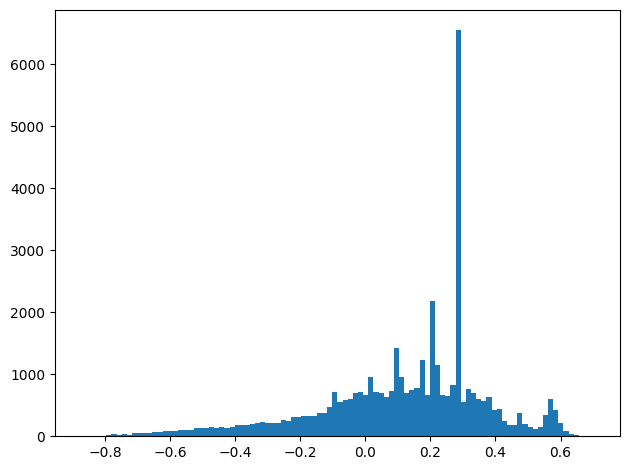

In [49]:
with open(f"checkpoints/8.pkl", "rb") as file:
    buffer = pickle.load(file)
    print(buffer.size)

buffer._obss = buffer._obss[:, new_obs_space_indices]
buffer.compute_values()
train_buffer, val_buffer = buffer.split_buffer(0.2)
# pvnet = PVNet(env.observation_space, env.action_space)
pvnet = PVNet(new_observation_space, env.action_space)
pvnet.train(train_buffer=train_buffer, val_buffer=val_buffer, batch_size=64, epochs=20)

prob_preds, value_preds = pvnet.forward(torch.tensor(buffer.obss).to(torch.float32))

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(value_preds.detach().numpy().squeeze(), bins=100)

[0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 2 2 1 1 2 2 1 1 2
 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 2
 1 2 2 1 1 2 2 1 1 2 2 1 0 2 2 0 0 3 3 0 0 3 3 0 0 3 3 0 0 3 3 0 0 4 4 0 0
 4 4 1 1 4 4 2 2 4 4 3 3 4 4 3 3 4 4 3 1 4 4 1 1 4 3 1 1 3 3 3 1 1 4 4 1 1
 4 4 1 1 5 5]
winning player: [0.]


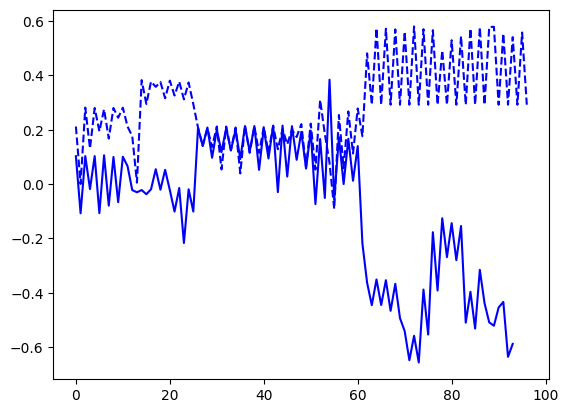

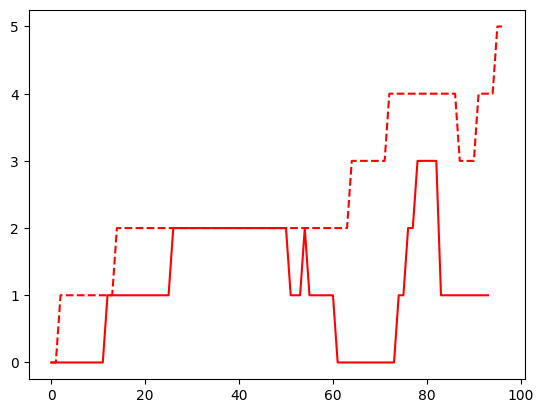

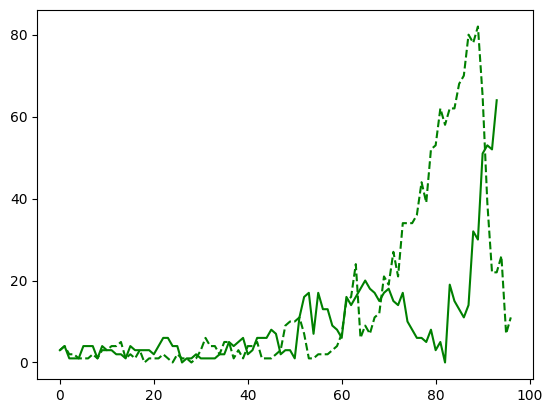

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 1 2 2 1 1 2 2 1 1 3 3
 1 1 3 3 1 1 3 3 1 1 3 3 1 1 3 3 1 1 3 3 1 1 4 4 1 1 4 4 2 2 4 4 2 2 4 4 2
 2 4 4 2 2 4 4 2 2 4 4 2 2 4 4 2 2 4 4 2 0 4 4 1 1 4 4 1 1 4 4 1 1 5 5]
winning player: [1.]


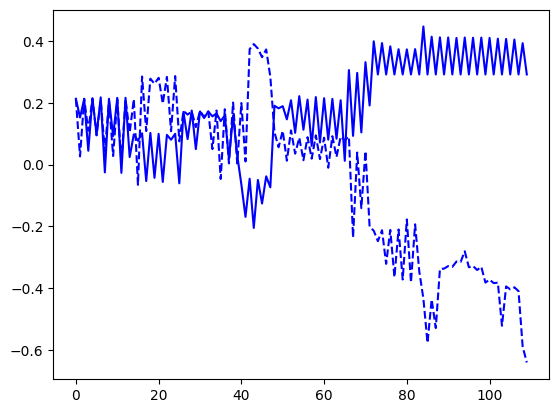

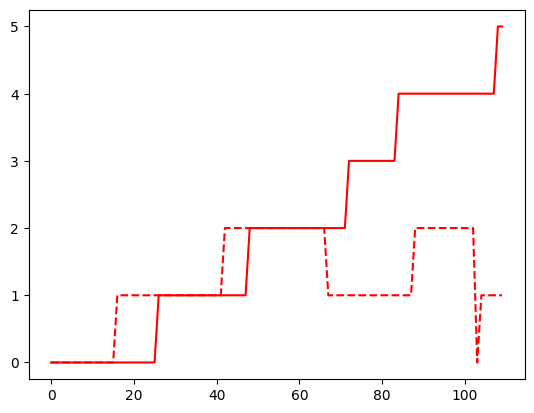

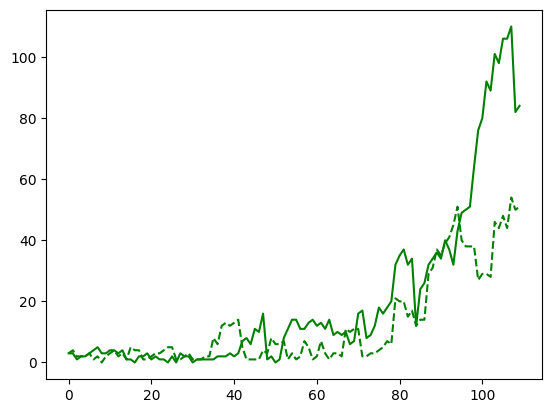

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0
 0 1 1 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0
 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2
 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2
 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 1 1 2 2 1 1 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 0 3 3 0 0 3 3 0 0 3 2 1 1 2 2 1 1 2 2 1 1 2 2 1 0
 2 2 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 2 2 0 0 3 3 1 1 3 3
 1 1 3 3 2 2 3 3 2 2 3 3 2 2 3 3 2 1 3 3 1 1 4 4 1 1 4 4 1 1 4 4 2 1 4 4 1
 1 4 4 1 1 4 4 2 2 5 5]
winning player: [0.]


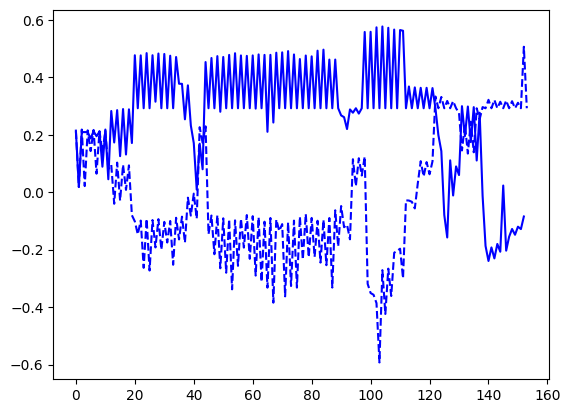

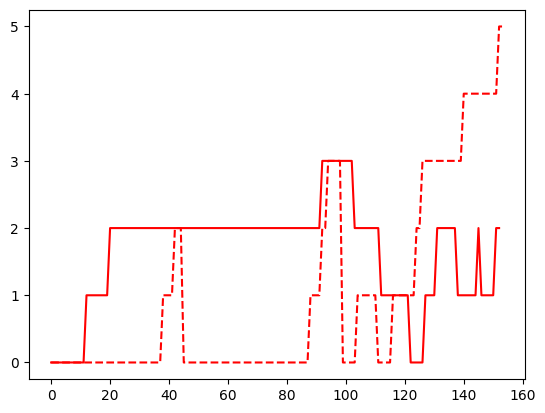

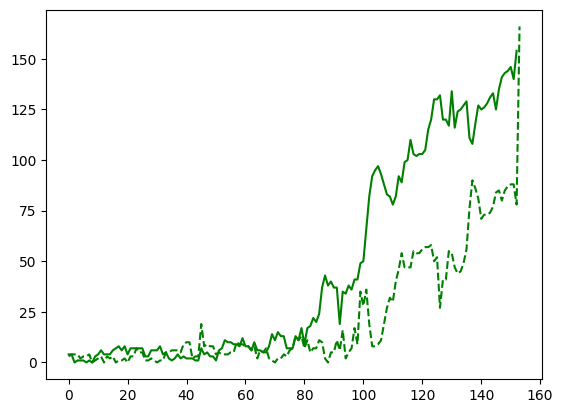

[0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0
 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0
 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 2 2 0
 0 3 2 0 0 2 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0
 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 2 2 3 2 2 0 3 3 0 0 3 3 1 1 3 3 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 4 4 3 3 5 5 4 1 5 5]
winning player: [1.]


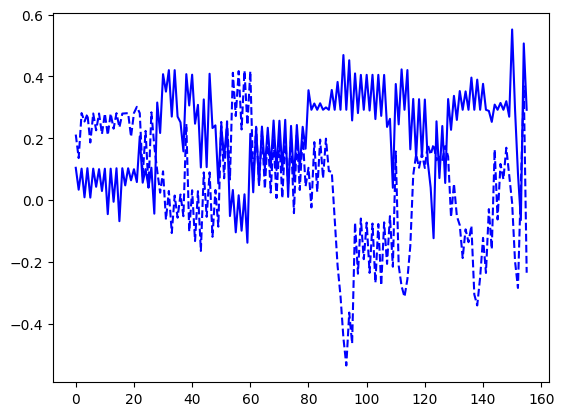

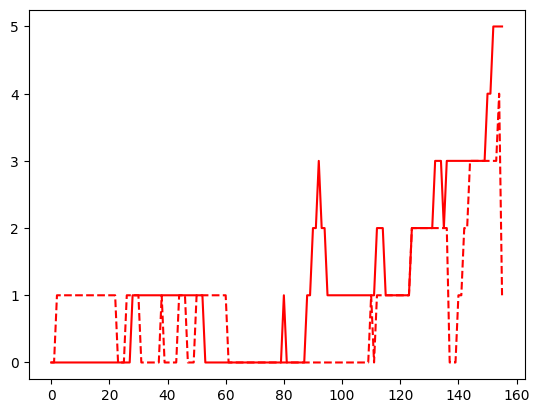

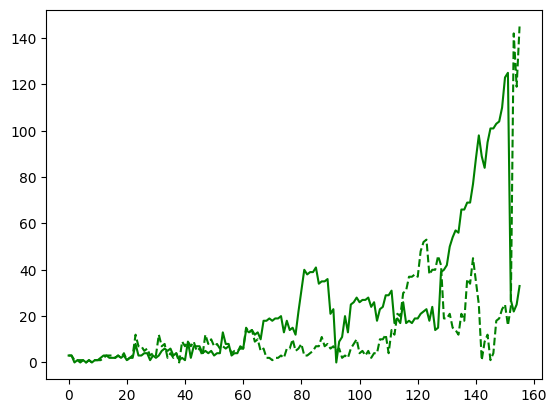

[0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1
 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2
 2 0 0 2 2 0 0 2 1 1 1 1 1 1 1 1 1 2 2 1 1 3 3 1 1 3 3 1 1 3 3 3 1 0 3 3 0
 0 3 3 0 0 3 3 0 0 3 3 0 0 3 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 2 2 1 1 2 2 2 2 2 2 2 2 2 1 2 2 1 0 2
 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 1 1 3 3 1 0 3 3 1 1 3 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0 0 2 2 0 0 2 2 0 0 2
 2 0 0 2 2 0 0 2 2 1 1 2 2 2 2 3 3 2 2 3 3 2 2 3 3 2 2 3 3 2 2 3 3 2 2 4 4
 2 2 4 4 3 3 5 5]
winning player: [1.]


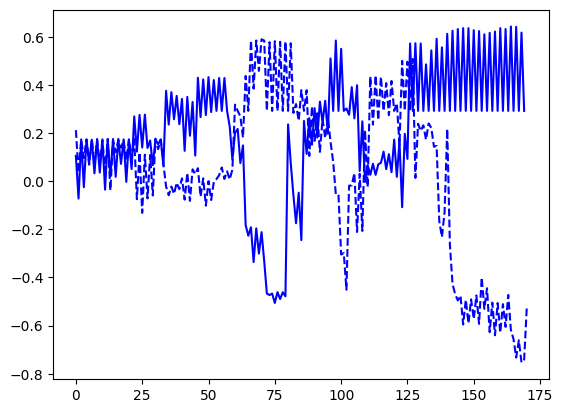

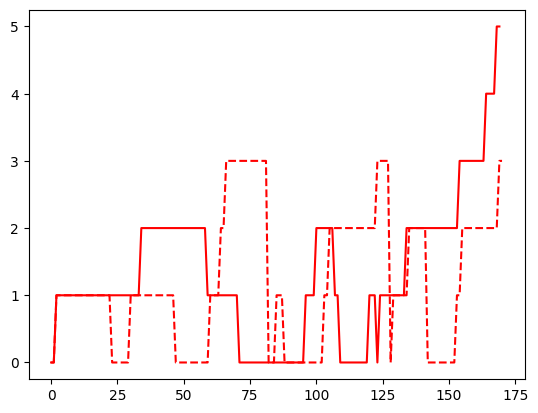

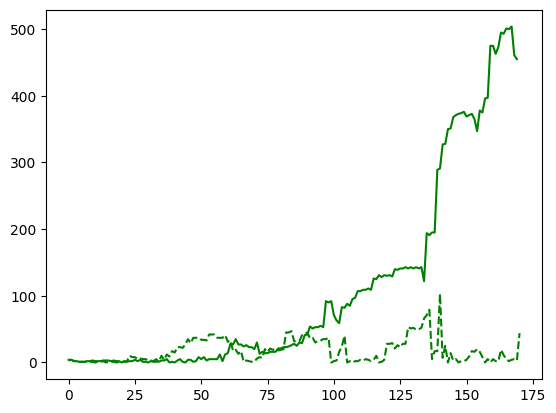

[0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0
 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 2 2 3 3 2 2 3 3 2 2 3 3 2 1 3 3 1 1 3 3 1 0 3 3 1 0 3 3 0 0 4 4 0 0 4 4
 0 0 4 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 3 3 1 1 4 4 2 2 4 4 2 2 4 4 2 2 4 4 2
 2 4 4 2 2 4 4 2 2 4 2 2 2 2 2 2 2 2 0 2 1 1 1 1 1 2 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 2
 2 1 1 2 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 2 0 1 1 0 0
 1 1 0 0 1 1 0 0 1 1 0 0 2 2 0 0 2 2 0 0 2 2 1 1 2 0 2 0 0 0 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 2 0 2 2 0 0 3 3 1 1
 3 3 2 2 4 4 3 3 5 5]
winning player: [1.]


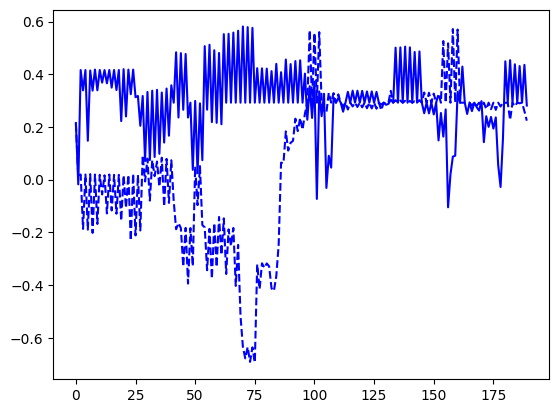

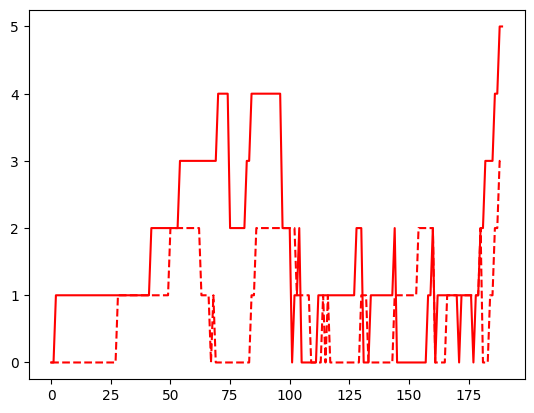

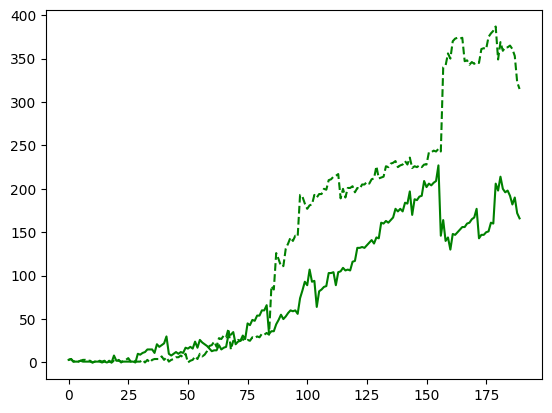

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 0 3 3 0 0 3 3 0 0 3 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0
 0 2 2 0 0 3 3 0 0 4 4 1 1 4 4 1 1 4 4 2 2 4 4 2 2 4 1 2 2 1 0 2 2 0 0 2 2
 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0
 0 0 0 1 1 0 0 2 2 1 1 2 2 1 1 3 0 1 1 1 1 1 1 1 1 2 2 1 1 3 3 1 1 3 3 1 1
 3 3 1 1 3 3 1 1 3 3 2 0 3 3 1 1 3 3 1 1 4 4 1 1 5 5]
winning player: [1.]


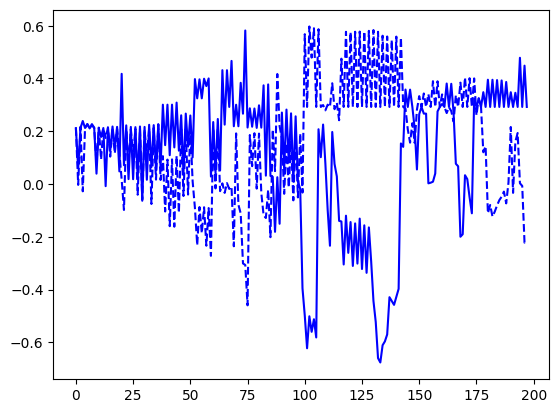

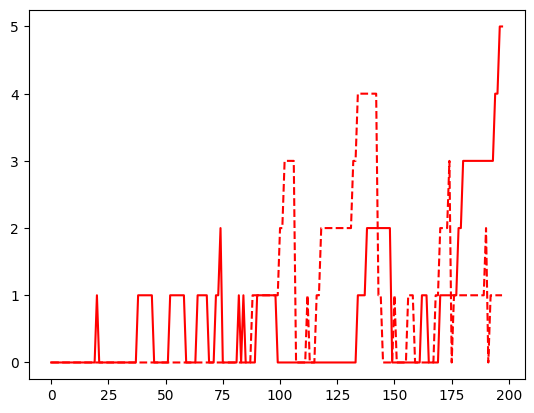

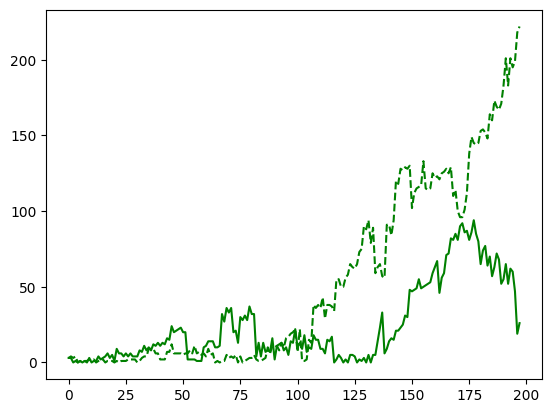

[0 0 0 0 1 1 1 1 1 1 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2
 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2
 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 2 2 3 3 2 2 3 0 2 2 0 0 2 2 0 0 2 2 1 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2
 0 0 2 2 1 1 2 2 1 1 2 0 1 1 0 0 1 1 1 1 2 2 1 1 2 0 1 1 0 0 1 0 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1
 0 0 1 1 0 0 1 1 0 0 2 2 0 0 2 2 0 0 2 2 0 0 2 2 0 0 3 3 0 0 4 4 1 1 4 4 1
 0 5 5]
winning player: [0.]


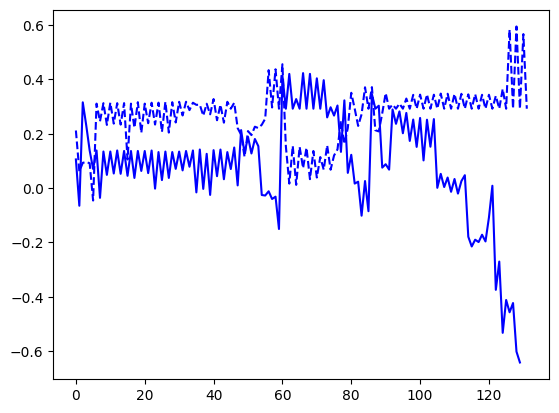

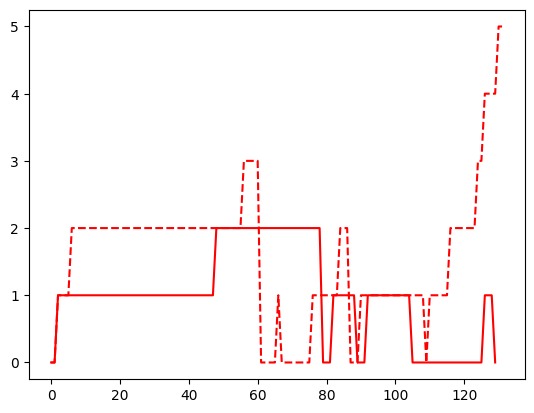

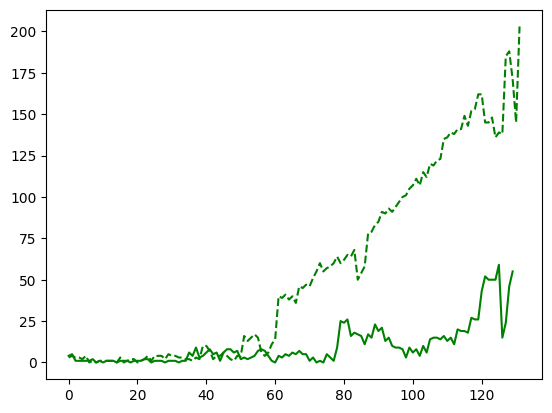

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 1 1 3 3 1 1 3 3 1 1 4 4 1
 0 4 4 0 0 4 4 0 0 5 5 0 0 5 5 0 0 5 5]
winning player: [0.]


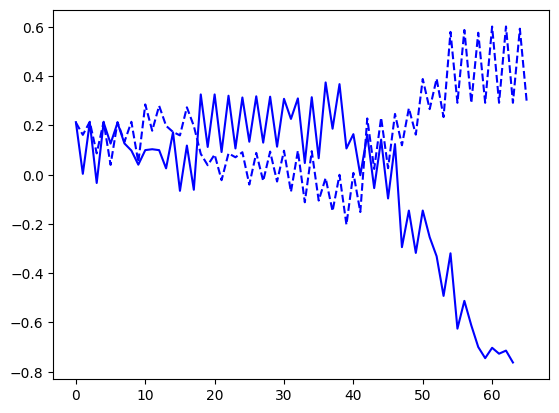

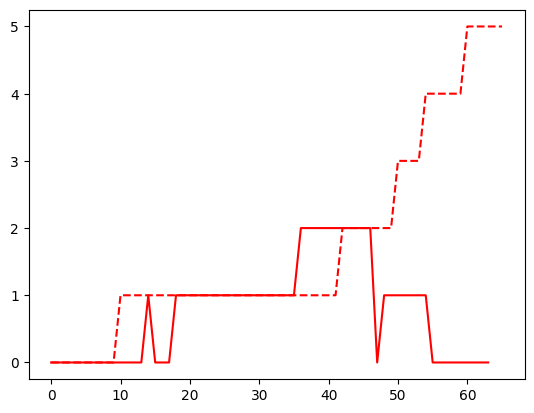

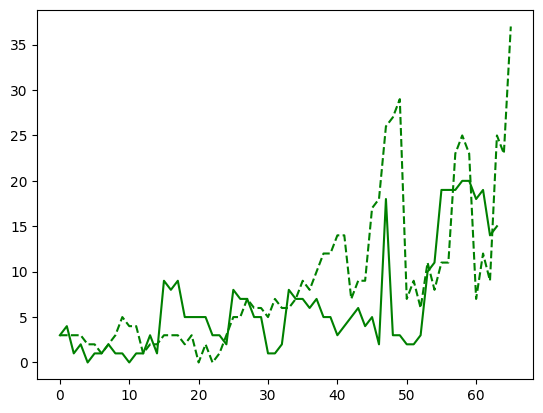

[0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 3 2 1 1 2 2 1 1
 2 1 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 3 2 1 1 2 2 1 1 3
 3 1 1 3 3 1 1 3 3 1 1 4 4 1 1 4 4 1 1 4 4 2 2 4 4 2 2 4 4 2 0 4 4 1 0 5 5
 4 0 0 4 4 1 1 4 4 1 1 4 4 1 1 4 4 2 2 4 4 2 2 5 5]
winning player: [0.]


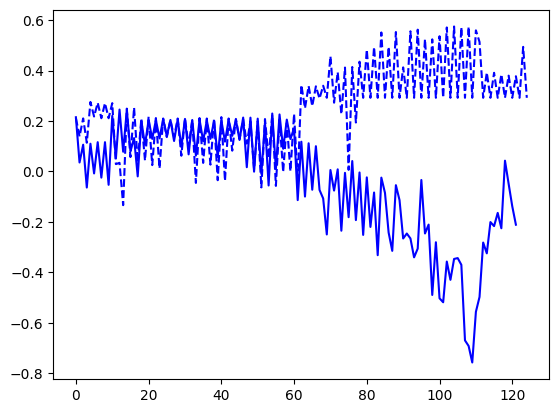

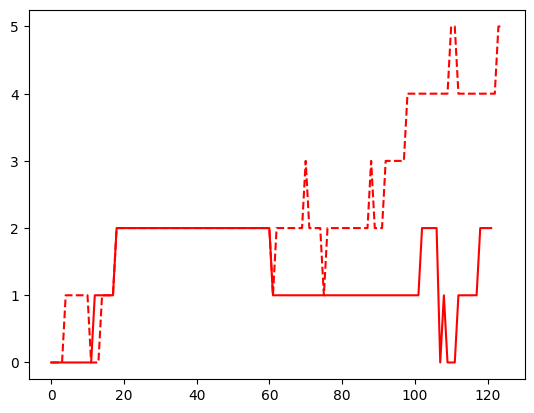

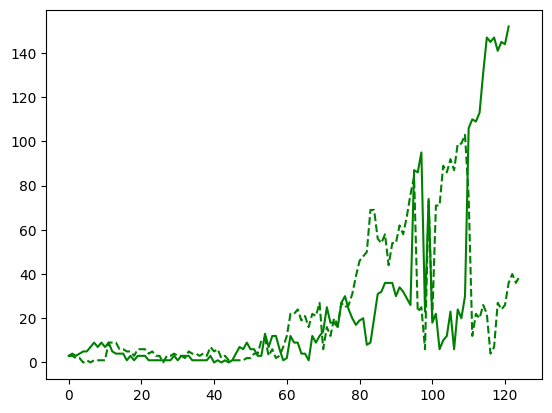

In [51]:
for i in range(10):
    obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = buffer.get_episode(i)
    cur_player_coins = []
    cur_player_landmarks = []
    for obs in obss:
        # obs_unfl = gym.spaces.unflatten(env.observation_space, obs)
        obs_unfl = gym.spaces.unflatten(new_observation_space, obs)
        cur_player_coins.append(obs_unfl["current_player-coins"][0])
        landmarks = 0
        for landmark in env.player_info["player 0"]._landmarks:
            landmarks += obs_unfl[f"current_player-{landmark}"][1]
        cur_player_landmarks.append(landmarks)

    cur_player_coins = np.array(cur_player_coins)
    cur_player_landmarks = np.array(cur_player_landmarks)
    print(cur_player_landmarks)
    prob_preds, value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
    p0_indices, _ = np.where(player_ids == 0)
    p1_indices, _  = np.where(player_ids == 1)
    print(f"winning player: {player_ids[-1]}")
    plt.plot(np.arange(len(p0_indices)), value_preds[p0_indices].detach().numpy(), "b--")
    plt.plot(np.arange(len(p1_indices)), value_preds[p1_indices].detach().numpy(), "b-")
    plt.show()
    plt.plot(np.arange(len(p0_indices)), cur_player_landmarks[p0_indices], "r--")
    plt.plot(np.arange(len(p1_indices)), cur_player_landmarks[p1_indices], "r-")
    plt.show()
    plt.plot(np.arange(len(p0_indices)), cur_player_coins[p0_indices], "g--")
    plt.plot(np.arange(len(p1_indices)), cur_player_coins[p1_indices], "g-")
    plt.show()

winning player: [1.]


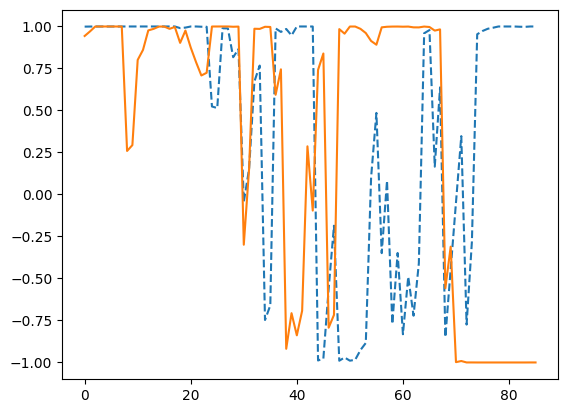

winning player: [0.]


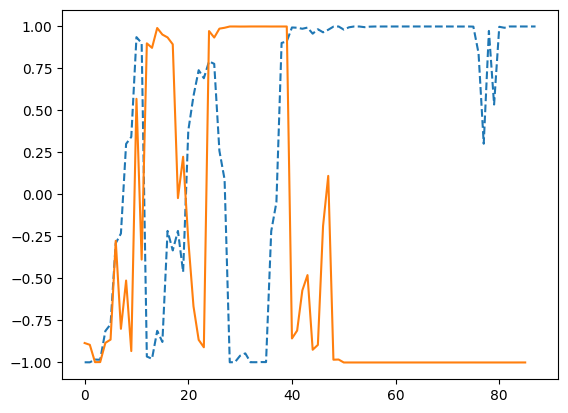

winning player: [0.]


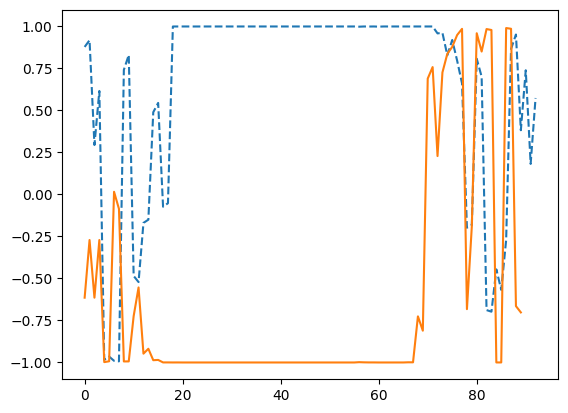

winning player: [1.]


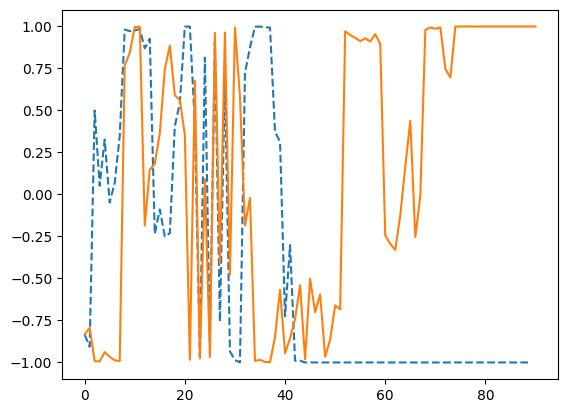

winning player: [1.]


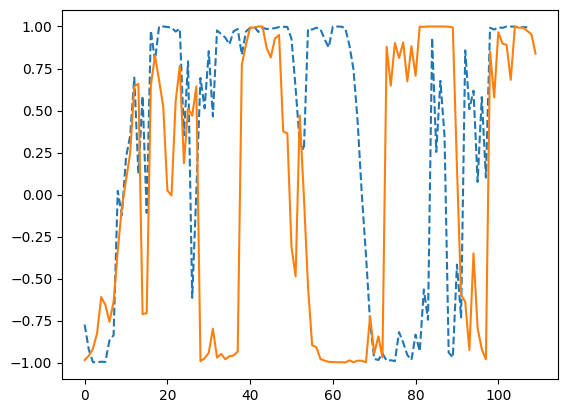

winning player: [0.]


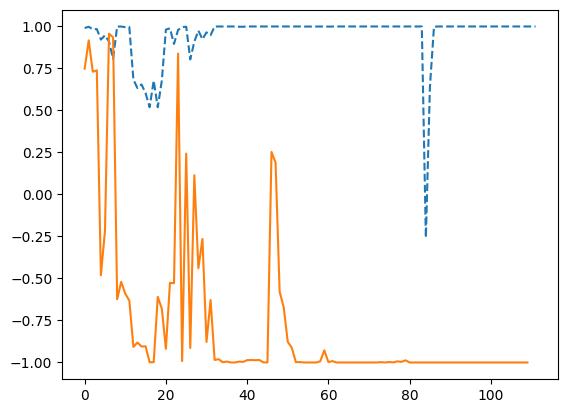

winning player: [1.]


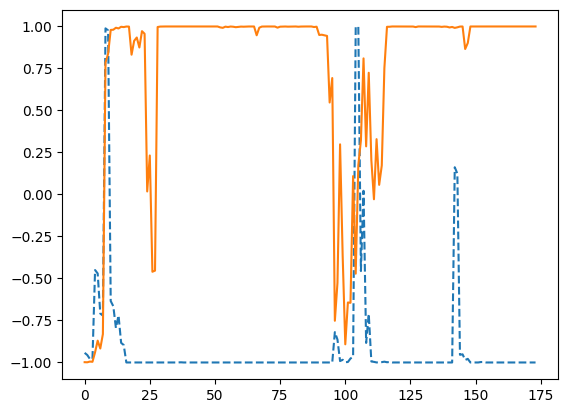

winning player: [1.]


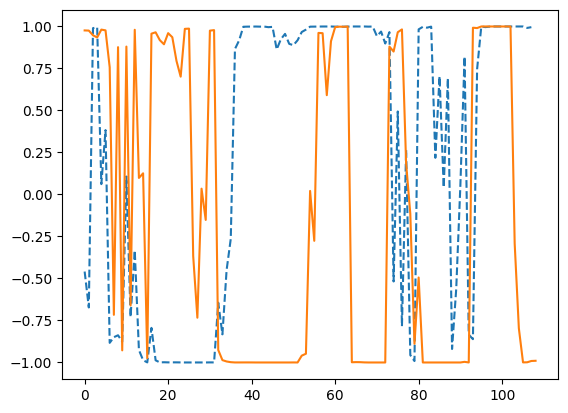

winning player: [1.]


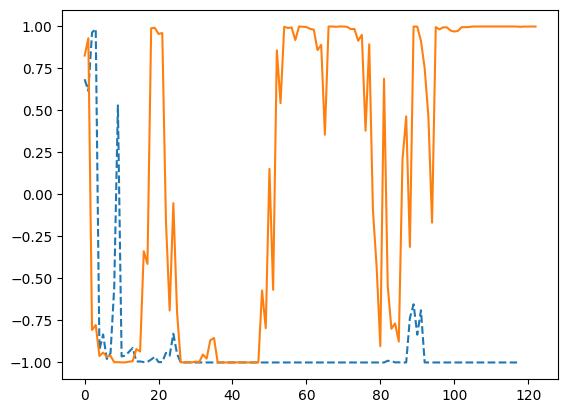

winning player: [0.]


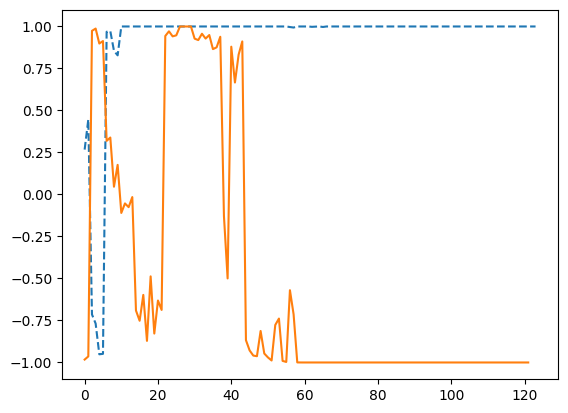

In [12]:
for i in range(10):
    obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = buffer.get_episode(i)
    prob_preds, value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
    p0_indices, _ = np.where(player_ids == 0)
    p1_indices, _  = np.where(player_ids == 1)
    print(f"winning player: {player_ids[-1]}")
    plt.plot(np.arange(len(p0_indices)), value_preds[p0_indices].detach().numpy(), "--")
    plt.plot(np.arange(len(p1_indices)), value_preds[p1_indices].detach().numpy(), "-")
    plt.show()
# [print(f"{v=}, {p=}, a= {env._action_idx_to_str[a.item()]}") for v, p, a in zip(value_preds, player_ids, actions)]

v=tensor([-0.1652], grad_fn=<UnbindBackward0>), p=array([0.]), a= 1 dice
v=tensor([0.0203], grad_fn=<UnbindBackward0>), p=array([0.]), a= Mackerel Boat
v=tensor([0.4254], grad_fn=<UnbindBackward0>), p=array([1.]), a= 1 dice
v=tensor([0.6350], grad_fn=<UnbindBackward0>), p=array([1.]), a= Airport
v=tensor([-0.6609], grad_fn=<UnbindBackward0>), p=array([0.]), a= 1 dice
v=tensor([-0.7598], grad_fn=<UnbindBackward0>), p=array([0.]), a= Build nothing
v=tensor([0.9028], grad_fn=<UnbindBackward0>), p=array([1.]), a= 1 dice
v=tensor([0.8811], grad_fn=<UnbindBackward0>), p=array([1.]), a= Build nothing
v=tensor([-0.8607], grad_fn=<UnbindBackward0>), p=array([0.]), a= 1 dice
v=tensor([-0.9199], grad_fn=<UnbindBackward0>), p=array([0.]), a= Build nothing
v=tensor([0.9537], grad_fn=<UnbindBackward0>), p=array([1.]), a= 1 dice
v=tensor([0.9783], grad_fn=<UnbindBackward0>), p=array([1.]), a= Member's Only Club
v=tensor([-0.9072], grad_fn=<UnbindBackward0>), p=array([0.]), a= 1 dice
v=tensor([-0.8493

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [33]:
player_ids.flatten()[:10]

array([0., 0., 1., 1., 0., 0., 1., 1., 0., 0.])

In [35]:
value_preds.flatten()[:10]

tensor([ 0.9994,  0.9954, -0.8554,  0.7111,  0.9949,  0.9899, -0.9984, -0.9788,
         0.9988,  0.9937], grad_fn=<SliceBackward0>)

In [39]:
gym.spaces.utils.unflatten(env.observation_space, obss[1]), gym.spaces.utils.unflatten(env.observation_space, obss[2])

(OrderedDict([('current_player-Wheat Field',
               array([0, 1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Ranch',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Flower Orchard',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Forest',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Mackerel Boat',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Apple Orchard',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Tuna Boat',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-General Store',
               array([1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Bakery',
               array([0, 1, 0, 0, 0, 0, 0, 0], dtype=int8)),
              ('current_player-Demolition Company',
               array([1,